In [1]:
import re

# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from imblearn.over_sampling import RandomOverSampler

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Using Google Collab T4 GPU

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
from google.colab import drive
drive.mount('/content/drive')
train_split = pd.read_csv('/content/drive/MyDrive/IT1244 final project/DL_train.csv')
test_split = pd.read_csv('/content/drive/MyDrive/IT1244 final project/DL_test.csv')

Mounted at /content/drive


In [5]:
train_split = train_split[['Content','rating']]
test_split = test_split[['Content','rating']]

In [6]:
train_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  40000 non-null  object
 1   rating   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [7]:
train_split.head()


,Content,rating
0,This movie is funny and suitable for any age. ...,6
1,In the old commercial for blank audio cassette...,7
2,The CinemaScope color cinematography of Leon S...,4
3,Get this film if at all possible. You will fin...,6
4,"While the soundtrack is a bit dated, this stor...",6


In [8]:
test_split.head()


,Content,rating
0,<br /><br />I would highly recommend seeing th...,1
1,I don't see why everyone loves this film so mu...,1
2,"Damn, I thought I'd seen some bad westerns. Ca...",1
3,Well it certainly stunned me - I can not belie...,1
4,Jefferey dahmer was one sick guy. There's not ...,1


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

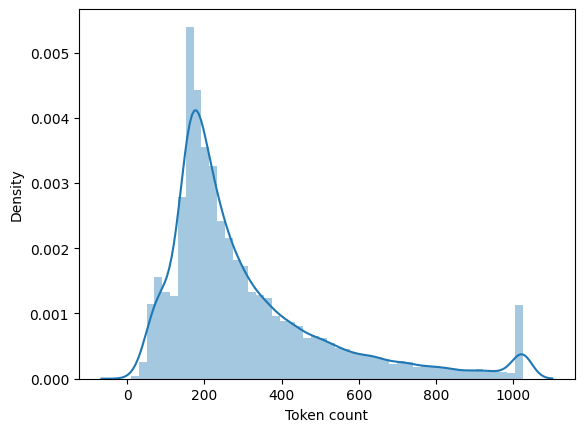

In [ ]:
token_lens = []

# Iterate through the content slide
for txt in train_split.Content:
    tokens = tokenizer.encode(txt, max_length=1024)
    token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlabel('Token count')

From the chart above, we can see that there are some reviews with length longer than the maximum length of tokens allowed by BERT models. THese reviews will be truncated during model training.

Ratings need to start at 0 due to formatting for loss function

In [9]:
train_split['rating'] = train_split['rating'] - 1
test_split['rating'] = test_split['rating'] - 1


In [10]:
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
from torch.utils.data import Dataset

class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        reviews = str(self.reviews[item]).lower()
        reviews = re.sub(r'<[^>]+>', '', reviews)
        reviews = re.sub(r'https://\S+|www\.\S+', '', reviews)
        reviews = " ".join(reviews.split())
        target = self.targets[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            reviews,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': reviews,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [12]:
df_train = train_split
df_val, df_test = train_test_split(test_split, test_size=0.5)

print(df_train.shape, df_val.shape, df_test.shape)

(40000, 2) (5000, 2) (5000, 2)


In [13]:
df_train.head()

,Content,rating
0,This movie is funny and suitable for any age. ...,5
1,In the old commercial for blank audio cassette...,6
2,The CinemaScope color cinematography of Leon S...,3
3,Get this film if at all possible. You will fin...,5
4,"While the soundtrack is a bit dated, this stor...",5


In [14]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.Content.to_numpy(),
        targets=df.rating.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [15]:
BATCH_SIZE = 16
MAX_LEN = 512

In [16]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [17]:
train_data_loader

In [18]:
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


In [19]:
bert_model = BertModel.from_pretrained(MODEL_NAME)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [20]:
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
    # Passing inputs through the BERT model
      outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      pooled_output = outputs[1]  # Getting the pooled output
      print("Type of pooled_output:", type(pooled_output))
      print("Shape of pooled_output:", pooled_output.shape)

      # Applying dropout
      output_after_dropout = self.drop(pooled_output)
      print("Shape of output after dropout:", output_after_dropout.shape)

      # Final linear layer
      return self.out(output_after_dropout)

In [21]:
levels = len(df_train['rating'].unique())
model = SentimentClassifier(levels)
model = model.to(device)

In [22]:
print(bert_model.config.hidden_size)


768


In [23]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 512])
torch.Size([16, 512])


In [24]:
EPOCHS = 1
LEARNING_RATE = 1e-05
# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [49]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Streaming output truncated to the last 5000 lines.
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')
Type of pooled_output: <class 'torch.Tensor'>
Shape of pooled_output: torch.Size([16, 768])
Shape of output after dropout: torch.Size([16, 768])
<class 'torch.Tensor'>
tensor([[ 101, 1111, 1343,  ...,    0,    0,    0],
        [ 101,  178, 1821,  ...,    0,    0,    0],
        [ 101, 1218,  117,  ..., 9372, 1105,  102],
        ...,
        [ 101, 3805, 1106,  ...,    0,    0,    0],
        [ 101, 1297, 3471,  ...,    0,    0,    0],
        [ 101, 4348, 2254,  ...,    0,    0,    0]], device='cuda:0')
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')
Type of pooled_output: <class 'torch.Tensor'>
Shape of pooled_output: torch.Size([1

With 8 categories: Val   loss 2.030277620489224 accuracy 0.2048

Accuracy is at 0.2048. Time to try out a differnet number of Sentiments
